In [13]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import random as rd
from sklearn import neighbors
import sklearn
import time


mat = scipy.io.loadmat('mnist-original.mat') 
data = np.transpose(mat['data'])
label = np.transpose(mat['label'])
X = [data[i].reshape(784,1) for i in range(len(data))] # on créé une nouvelle liste qui va contenir nos matrices 28x28

k=15 # nombre de cluster utilisé
m=70000 # nombre de données utilisées
n=784  
tol=10**(11)

[37360, 43044, 32444, 53692, 53182, 3688, 23748, 25061, 65595, 69713, 63437, 33244, 126, 34608, 21736]
5358


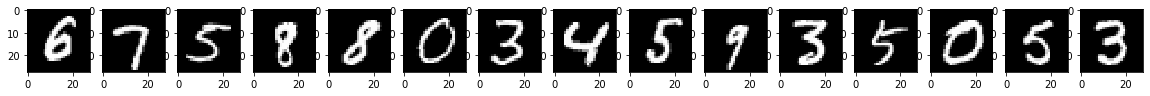

In [14]:
# on initialise les centroides aléatoirement et on associe les données correspondantes 
clusters = {}
for i in range(k):
    clusters[i] = []
index=[]    
centroids= {}
for i in range(k):
    rand=rd.randint(0,m-1)
    index.append(rand)
    centroids[i] = X[rand]
    
fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')

indice=[[] for i in range(k)]
for i in range(m):
    euc_dist = [np.linalg.norm(X[i] - centroids[j]) for j in range(k)]
    minn=np.argmin(np.asarray(euc_dist))
    clusters[minn].append(X[i])
    indice[minn].append(i)
print(index)
print(len(indice[1]))

In [15]:
def re_clusters(X, centroids, k):# fonction qui recalcule les clusters
    clusters = {}
    indice=[[] for i in range(k)]
    for i in range(k):
        clusters[i] = []
    for i in range(m):
        euc_dist = [np.linalg.norm(X[i] - centroids[j]) for j in range(k)]
        clusters[np.argmin(np.asarray(euc_dist))].append(X[i])
        indice[np.argmin(np.asarray(euc_dist))].append(i)
    return [clusters,indice]

def re_centroids(clusters, k):# fonction qui recalcule les centroids
    centroids= {}
    for i in range(k):
        centroids[i] = np.mean(clusters[i], axis=0)
        
    return centroids

def coherence(centroids_j, clusters_j):
    temp=[np.linalg.norm(data - centroids_j)**2 for data in clusters_j ]
    return sum(temp)

def quality(centroids, clusters):
    temp=[coherence(centroids[i],clusters[i]) for i in range(k)]
    return sum(temp)

In [16]:
clusters_nv=re_clusters(X, centroids, k)[0]
centroids_nv=re_centroids(clusters, k)
L=[]
start=time.time()
while abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv))>tol :
    L.append(abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv)))
    centroids=centroids_nv
    clusters=clusters_nv
    clusters_nv=re_clusters(X, centroids, k)[0]
    centroids_nv=re_centroids(clusters_nv, k)
end=time.time()

2
Temps de réalisation : 11.65139889717102 secondes


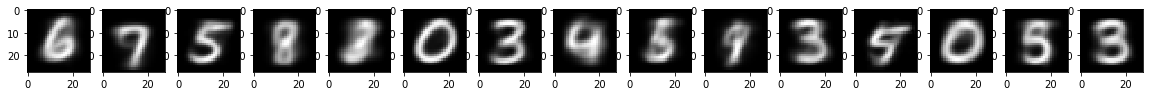

In [17]:
L.append(abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv)))
print(len(L))
print("Temps de réalisation : " + str(end-start) + " secondes")
fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')

In [18]:
indice=[[] for i in range(k)]
start=time.time()
for i in range(m):
    euc_dist = [np.linalg.norm(X[i] - centroids[j]) for j in range(k)]
    minn=np.argmin(np.asarray(euc_dist))
    clusters[minn].append(X[i])
    indice[minn].append(i)
end=time.time()
print("Temps de réalisation : " + str(end-start) + " secondes")

Temps de réalisation : 8.05737018585205 secondes


In [19]:
#compter le nb d'éléments : x = chaque chiffre et labels = liste des labels 
def nb_occurences(x,labels):
    n=0
    for i in labels:
        if x==i:
            n=n+1
    return n

#Label majoritaire dans chaque cluster 
def majoritaire(l):
    xmaj=l[0]
    nbmaj=nb_occurences(xmaj,l)
    for i in range(1,len(l)):
        if nb_occurences(l[i],l)>nbmaj:
            xmaj=l[i]
            nbmaj=nb_occurences(l[i],l)
    return xmaj

In [20]:
#Liste des labels représentés dans chaque classe 
start=time.time()
labels_clusters = [[] for _ in range(k)]
for i in range(len(indice)):
    for j in indice[i]:
        labels_clusters[i].append(label[j])
end=time.time()
print('Temps de réalisation : '+str(end-start)+' secondes.')

Temps de réalisation : 0.03990292549133301 secondes.


In [21]:
classes = []       #liste des chiffres majoritaires pour chaque cluster  
start=time.time()
for i in range(k):
    classes.append(majoritaire(labels_clusters[i]))
end=time.time()
print('Temps de réalisation : '+str(end-start)+' secondes.')

Temps de réalisation : 246.35337805747986 secondes.


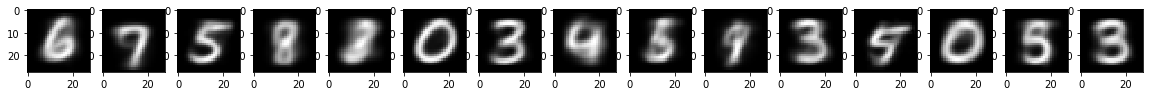

In [22]:
#Je les remontre pour voir si ça correspond bien. 

fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')

In [23]:
classes

[array([6.]),
 array([7.]),
 array([5.]),
 array([8.]),
 array([2.]),
 array([0.]),
 array([3.]),
 array([4.]),
 array([6.]),
 array([1.]),
 array([3.]),
 array([4.]),
 array([0.]),
 array([5.]),
 array([3.])]

In [26]:
#calcul précision : 

def calcul_pourcentage(cl):# renvoie le pourcentage de réussite 
    precision = []
    for _ in range(len(cl)):
        A =[i for i in labels_clusters[_] if i==cl[_]]
        precision.append(len(A)*100/len(labels_clusters[_]))
    #print(precision)    --> donne la précision de chaque centroïde
    print('La précision globale est de '+str(np.mean(precision))+'%.')

In [28]:
calcul_pourcentage(classes)

La précision globale est de 56.8321385364438%.
